## Based Class

In [309]:
from abc import ABC, abstractmethod

class Layer:
    def forward (self, x):
        raise NotImplementedError
    
    def backward (self, grad):
        raise NotImplementedError
    
    def train(self):
        pass
    
    def eval(self):
        pass
    
    def parameters(self):
        return []
            
class Optimizer(ABC):
    def __init__(self, parameters):
        self.parameters = parameters
    
    @abstractmethod
    def step(self):
        raise NotImplementedError("Optimizer must implement step()")
    
    def zero_grad(self):
         for param in self.parameters:
            if "dW" in param:
                param["dW"]().fill(0)
            if "db" in param:
                param["db"]().fill(0)

class Loss:
    def compute_loss(self, y_pred, y_true): 
        raise NotImplementedError
    
class DataSet(ABC):
    @abstractmethod
    def __len__(self):
        raise NotImplementedError
    
    @abstractmethod
    def __getitem__(self, index):
        raise NotImplementedError
    
    @abstractmethod
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
            

## Activation Functions Layer

In [310]:
import numpy as np
class Sigmoid(Layer):
    def __init__(self):
        pass
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def forward(self, x):
        self.x = x
        self.y = self.sigmoid(self.x)
        return self.y
    
    def backward(self, d):
        sig = self.sigmoid(self.x)
        return d*sig*(1-sig)

In [311]:
class Relu(Layer):
    def __init__(self):
        pass
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def forward(self, x):
        self.x = x
        self.y = self.relu(self.x)
        return self.y
    
    def backward(self, d):
        r = self.x > 0
        return d*r

In [312]:
class LeakyRelu(Layer):
    def __init__(self):
        pass
    
    def leaky_relu(self, x):
        s = np.ones_like(x) / 10
        s[x > 0] = 1
        return s
    
    def forward(self, x):
        self.x = x
        self.y = self.leaky_relu(self.x)
        return self.y
    
    def backward(self, d):
        s = np.ones_like(self.x)/10
        s[self.x > 0] = 1
        return d*s

In [313]:
class Tanh(Layer):
    def __init__(self):
        pass
    
    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def forward(self, x):
        self.x = x
        self.y = self.tanh(self.x)
        return self.y
    
    def backward(self, d):
        t = 1-self.tanh(self.x)**2
        return d*t

In [314]:
class Softmax(Layer):
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
        self.y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.y

    def backward(self, d):
        return d  

## Fully Conneted Layer

In [315]:
class FullyConnected(Layer):
    def __init__(self, input_dim, output_dim):
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)  
        self.b = np.zeros((output_dim, 1))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.x = None

    def forward(self, x):
        self.x = x  # x: (batch_size, input_dim)
        return np.dot(x, self.W.T) + self.b.T  # output: (batch_size, output_dim)

    def backward(self, d):
        # d: (batch_size, output_dim)
        self.dW = np.dot(d.T, self.x) / d.shape[0]  # (output_dim, input_dim)
        self.db = np.sum(d, axis=0, keepdims=True).T / d.shape[0]  # (output_dim, 1)
        return np.dot(d, self.W)  # (batch_size, input_dim)

    def parameters(self):
        return [{
            "W": lambda: self.W, 
            "b": lambda: self.b, 
            "dW": lambda: self.dW, 
            "db": lambda: self.db,
            "set_W": lambda new_W: setattr(self, "W", new_W), 
            "set_b": lambda new_b: setattr(self, "b", new_b)  
        }]

    def zero_grad(self):
        self.dW.fill(0)  
        self.db.fill(0)

In [316]:
# fc = FullyConnected(2, 3)
# fc.forward(np.array([1,1]).reshape(2,1))
# y = np.random.randn(3, 1)
# x = fc.backward(y)
# x

## Loss Function

In [317]:
class MSE(Loss):
    @staticmethod
    def compute_loss(y_pred, y_true):
        loss = np.mean((y_pred - y_true) ** 2)
        grad = 2 * (y_pred - y_true) / y_pred.size  # 按照所有元素的平均值进行归一化
        return loss, grad

In [318]:
# loss = MSE()
# y_p = np.array([1, 1, 2, 3]).reshape(2, -1)
# y_t = np.array([1.1, 0.8, 2.1, 2.8]).reshape(2, -1)
# loss.compute_loss(y_p, y_t) 


In [319]:
class CrossEntropy(Loss):
    @staticmethod
    def compute_loss(y_pred, y_true):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        grad = (y_pred - y_true) / y_pred.shape[0] 
        return loss, grad

In [320]:
# loss = CrossEntropy()
# y_p = np.array([1, 1, 2, 3]).reshape(-1, 2)
# y_t = np.array([1.1, 0.8, 2.1, 2.8]).reshape(-1, 2)
# loss.compute_loss(y_p, y_t) 


## Normalization Layer

In [321]:
class Dropout(Layer):
    def __init__(self, p=0.5):
        self.p = p
        self.mask = None
        self.is_training = False
        
    def forward(self, x):
        self.mask = np.random.rand(*x.shape) < (1 - self.p) 
        if  self.is_training:
            return x * self.mask /  (1 - self.p)
        else:
            return x
    
    def backward(self, grad):
        if self.is_training:
            return grad * self.mask
        else:
            return grad
    
    def train(self):
        self.is_training = True
        
    def eval(self):
        self.is_training = False

## Optimizer

In [322]:
class SGD(Optimizer):
    def __init__(self, parameters, lr=0.01):
        super().__init__(parameters)
        self.lr = lr

    def step(self):
        for param in self.parameters:
            for key in ['W', 'b']:
                g = param[f'd{key}']()  
                new_value = param[key]() - self.lr * g 
                param[f"set_{key}"](new_value)  

In [323]:
class Adam(Optimizer):
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(parameters)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [{k: np.zeros_like(param[k]) for k in ['W', 'b']} for param in parameters]
        self.v = [{k: np.zeros_like(param[k]) for k in ['W', 'b']} for param in parameters]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.parameters):
            for key in ['W', 'b']:
                g = param[f'd{key}']()  
                self.m[i][key] = self.beta1 * self.m[i][key] + (1 - self.beta1) * g
                self.v[i][key] = self.beta2 * self.v[i][key] + (1 - self.beta2) * (g ** 2)
                m_hat = self.m[i][key] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i][key] / (1 - self.beta2 ** self.t)
    
                new_value = param[key]() - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)  
                param[f"set_{key}"](new_value)  

## Net

In [324]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

## DataSet

In [325]:
class TensorDataSet(DataSet):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is not None:
            y = self.y[idx]
        else:
            y = None
        
        if self.transform is not None:
            x = self.transform(x)
        
        return (x, y) if y is not None else x
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
    
    
    

## DataLoader

In [326]:
class DataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataset))
        
    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i+self.batch_size]
            batch = [self.dataset[idx] for idx in batch_indices]
            
            x_batch = np.stack([item[0] for item in batch])
            y_batch = np.stack([item[1] for item in batch])
            
            yield (x_batch, y_batch) if y_batch is not None else x_batch
    
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

##  Metrics

In [327]:
class Metrics:
    @staticmethod
    def accuracy(y_pred, y_true):
        y_pred = np.argmax(y_pred, axis=1)
        return  np.mean(y_pred == y_true)
    

## Train

In [344]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, test_losses, train_accs, test_accs):
    """可视化训练指标的内部函数"""
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12, 4))
    
    # Loss曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, test_accs, 'r-', label='Test Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [360]:
import time

def train(model, train_loader, test_loader, criterion, optimizer, epochs, plot=True):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for img, label in train_loader:
            optimizer.zero_grad()
            output = model.forward(img)
            loss, grad = criterion.compute_loss(output, label)
            model.backward(grad)
            optimizer.step()
            train_loss += loss
            train_acc += Metrics.accuracy(output, np.argmax(label, axis=1))
            
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        for img, label in test_loader:
            output = model.forward(img)
            loss, _ = criterion.compute_loss(output, label)
            test_loss += loss
            test_acc += Metrics.accuracy(output, np.argmax(label, axis=1))
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Test Acc: {test_acc:.4f}")
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
    if plot:
        plot_metrics(train_losses, test_losses, train_accs, test_accs)
        

## MNIST

In [346]:
import numpy as np
import pandas as pd

# 加载 MNIST 数据集
df_train = pd.read_csv('MNIST/mnist_train.csv')
df_test = pd.read_csv('MNIST/mnist_test.csv')

# 提取图像数据和标签
X_train = np.array(df_train.iloc[:, 1:])  # 图像数据，形状 (60000, 784)
y_train = np.array(df_train.iloc[:, 0])   # 标签，形状 (60000,)

X_test = np.array(df_test.iloc[:, 1:])    # 图像数据，形状 (10000, 784)
y_test = np.array(df_test.iloc[:, 0])     # 标签，形状 (10000,)

# 归一化图像数据到 [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# 将标签转换为 one-hot 编码
y_train_onehot = np.eye(10)[y_train]  # 形状 (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # 形状 (10000, 10)

# 创建数据集
train_dataset_MNIST = TensorDataSet(X_train, y_train_onehot)
test_dataset_MNIST = TensorDataSet(X_test, y_test_onehot)

# 创建数据加载器
train_loader_MNIST = DataLoader(train_dataset_MNIST, batch_size=64, shuffle=True)
test_loader_MNIST = DataLoader(test_dataset_MNIST, batch_size=64, shuffle=False)

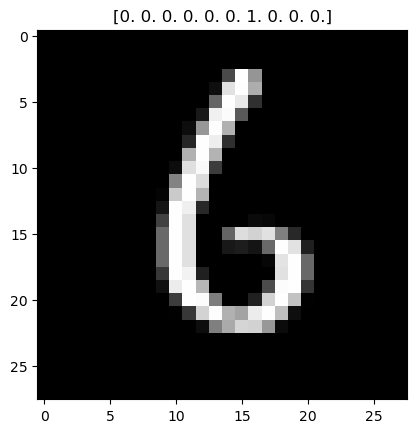

In [347]:
for x_batch, y_batch in train_loader_MNIST:
    break
   
x = x_batch[0]
y = y_batch[0]
    
def make_plt(x, title=None):
    plt.title(title)
    plt.imshow(x.reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.show()
    
make_plt(x, str(y))

In [348]:
import numpy as np
import pandas as pd

# 加载 MNIST 数据集
df_train = pd.read_csv('Fashion_MNIST/fashion-mnist_train.csv')
df_test = pd.read_csv('Fashion_MNIST/fashion-mnist_test.csv')

# 提取图像数据和标签
X_train = np.array(df_train.iloc[:, 1:])  # 图像数据，形状 (60000, 784)
y_train = np.array(df_train.iloc[:, 0])   # 标签，形状 (60000,)

X_test = np.array(df_test.iloc[:, 1:])    # 图像数据，形状 (10000, 784)
y_test = np.array(df_test.iloc[:, 0])     # 标签，形状 (10000,)

# 归一化图像数据到 [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# 将标签转换为 one-hot 编码
y_train_onehot = np.eye(10)[y_train]  # 形状 (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # 形状 (10000, 10)

# 创建数据集
train_dataset_Fashion_MNIST = TensorDataSet(X_train, y_train_onehot)
test_dataset_Fashion_MNIST = TensorDataSet(X_test, y_test_onehot)

# 创建数据加载器
train_loader_Fashion_MNIST = DataLoader(train_dataset_Fashion_MNIST, batch_size=64, shuffle=True)
test_loader_Fashion_MNIST = DataLoader(test_dataset_Fashion_MNIST, batch_size=64, shuffle=False)

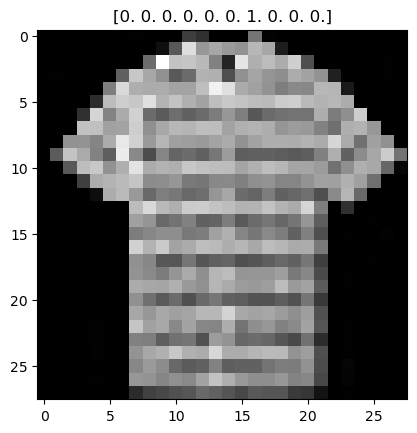

In [349]:
for x_batch, y_batch in train_loader_Fashion_MNIST:
    break
   
x = x_batch[0]
y = y_batch[0]
    
def make_plt(x, title=None):
    plt.title(title)
    plt.imshow(x.reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.show()
    
make_plt(x, str(y))

## Experiment


=== 开始实验: {'depth': [784, 28, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.6292 | Test Loss: 0.3103 | Train Acc: 0.8302 | Test Acc: 0.9152
Epoch 2/30 | Train Loss: 0.2863 | Test Loss: 0.2501 | Train Acc: 0.9200 | Test Acc: 0.9290
Epoch 3/30 | Train Loss: 0.2402 | Test Loss: 0.2216 | Train Acc: 0.9331 | Test Acc: 0.9360
Epoch 4/30 | Train Loss: 0.2134 | Test Loss: 0.2003 | Train Acc: 0.9405 | Test Acc: 0.9428
Epoch 5/30 | Train Loss: 0.1943 | Test Loss: 0.1866 | Train Acc: 0.9448 | Test Acc: 0.9448
Epoch 6/30 | Train Loss: 0.1794 | Test Loss: 0.1764 | Train Acc: 0.9492 | Test Acc: 0.9482
Epoch 7/30 | Train Loss: 0.1672 | Test Loss: 0.1648 | Train Acc: 0.9522 | Test Acc: 0.9509
Epoch 8/30 | Train Loss: 0.1573 | Test Loss: 0.1557 | Train Acc: 0.9551 | Test Acc: 0.9538
Epoch 9/30 | Train Loss: 0.1490 | Test Loss: 0.1507 | Train Acc: 0.9574 | Test Acc: 0.9553
Epoch 10/30 | Train Loss: 0.1414 | Test Loss: 0.1444 | Train Acc: 0

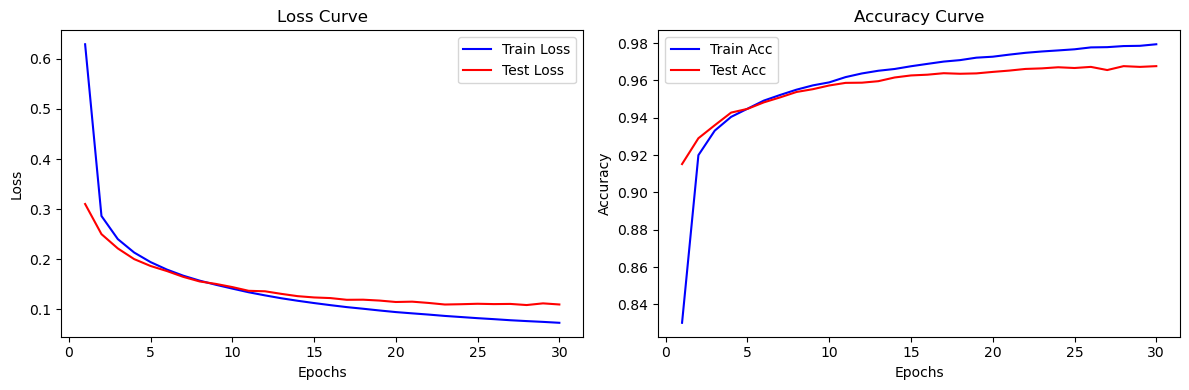


=== 开始实验: {'depth': [784, 28, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.7429 | Test Loss: 0.5327 | Train Acc: 0.7512 | Test Acc: 0.8217
Epoch 2/30 | Train Loss: 0.4927 | Test Loss: 0.4644 | Train Acc: 0.8322 | Test Acc: 0.8460
Epoch 3/30 | Train Loss: 0.4500 | Test Loss: 0.4430 | Train Acc: 0.8439 | Test Acc: 0.8510
Epoch 4/30 | Train Loss: 0.4252 | Test Loss: 0.4217 | Train Acc: 0.8523 | Test Acc: 0.8558
Epoch 5/30 | Train Loss: 0.4076 | Test Loss: 0.4082 | Train Acc: 0.8568 | Test Acc: 0.8610
Epoch 6/30 | Train Loss: 0.3950 | Test Loss: 0.4035 | Train Acc: 0.8613 | Test Acc: 0.8607
Epoch 7/30 | Train Loss: 0.3841 | Test Loss: 0.3880 | Train Acc: 0.8648 | Test Acc: 0.8675
Epoch 8/30 | Train Loss: 0.3757 | Test Loss: 0.3873 | Train Acc: 0.8675 | Test Acc: 0.8670
Epoch 9/30 | Train Loss: 0.3689 | Test Loss: 0.3882 | Train Acc: 0.8703 | Test Acc: 0.8655
Epoch 10/30 | Train Loss: 0.3640 | Test Loss: 0.3776 | Train Acc:

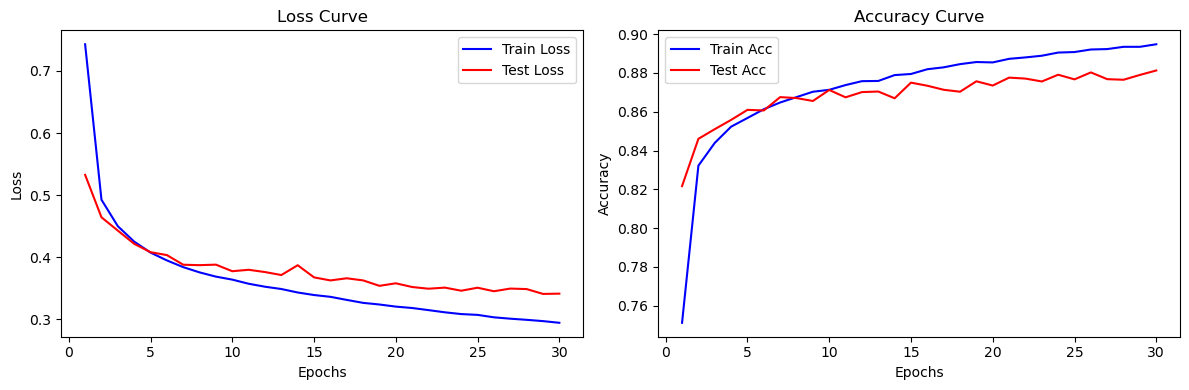


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.4861 | Test Loss: 0.1806 | Train Acc: 0.8544 | Test Acc: 0.9466
Epoch 2/30 | Train Loss: 0.2153 | Test Loss: 0.1285 | Train Acc: 0.9357 | Test Acc: 0.9611
Epoch 3/30 | Train Loss: 0.1703 | Test Loss: 0.1100 | Train Acc: 0.9496 | Test Acc: 0.9676
Epoch 4/30 | Train Loss: 0.1411 | Test Loss: 0.0943 | Train Acc: 0.9576 | Test Acc: 0.9707
Epoch 5/30 | Train Loss: 0.1203 | Test Loss: 0.0850 | Train Acc: 0.9630 | Test Acc: 0.9734
Epoch 6/30 | Train Loss: 0.1092 | Test Loss: 0.0782 | Train Acc: 0.9663 | Test Acc: 0.9747
Epoch 7/30 | Train Loss: 0.0982 | Test Loss: 0.0740 | Train Acc: 0.9694 | Test Acc: 0.9766
Epoch 8/30 | Train Loss: 0.0907 | Test Loss: 0.0709 | Train Acc: 0.9715 | Test Acc: 0.9782
Epoch 9/30 | Train Loss: 0.0829 | Test Loss: 0.0733 | Train Acc: 0.9746 | Test Acc: 0.9777
Epoch 10/30 | Train Loss: 0.0795 | Test Loss: 0.0673 | Train 

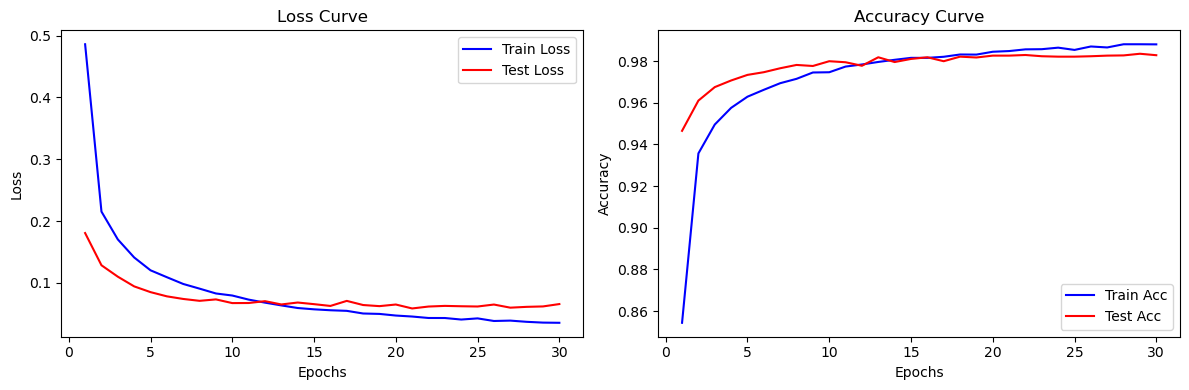


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.6617 | Test Loss: 0.4360 | Train Acc: 0.7681 | Test Acc: 0.8437
Epoch 2/30 | Train Loss: 0.4595 | Test Loss: 0.3938 | Train Acc: 0.8350 | Test Acc: 0.8569
Epoch 3/30 | Train Loss: 0.4191 | Test Loss: 0.3755 | Train Acc: 0.8500 | Test Acc: 0.8595
Epoch 4/30 | Train Loss: 0.3958 | Test Loss: 0.3481 | Train Acc: 0.8570 | Test Acc: 0.8724
Epoch 5/30 | Train Loss: 0.3765 | Test Loss: 0.3322 | Train Acc: 0.8635 | Test Acc: 0.8771
Epoch 6/30 | Train Loss: 0.3646 | Test Loss: 0.3280 | Train Acc: 0.8673 | Test Acc: 0.8799
Epoch 7/30 | Train Loss: 0.3532 | Test Loss: 0.3172 | Train Acc: 0.8702 | Test Acc: 0.8851
Epoch 8/30 | Train Loss: 0.3444 | Test Loss: 0.3171 | Train Acc: 0.8733 | Test Acc: 0.8858
Epoch 9/30 | Train Loss: 0.3341 | Test Loss: 0.3085 | Train Acc: 0.8772 | Test Acc: 0.8871
Epoch 10/30 | Train Loss: 0.3276 | Test Loss: 0.3056 | Trai

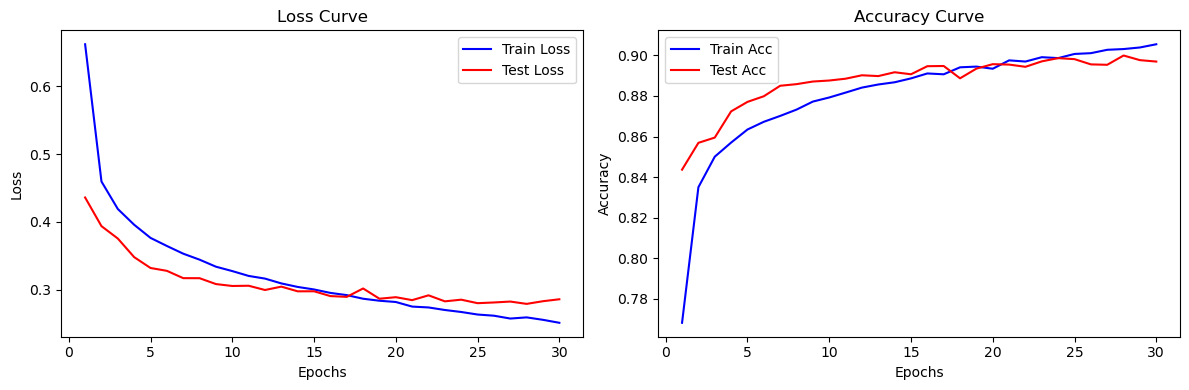


=== 开始实验: {'depth': [784, 512, 256, 128, 64, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.8798 | Test Loss: 0.2278 | Train Acc: 0.7095 | Test Acc: 0.9338
Epoch 2/30 | Train Loss: 0.3348 | Test Loss: 0.1554 | Train Acc: 0.9048 | Test Acc: 0.9525
Epoch 3/30 | Train Loss: 0.2402 | Test Loss: 0.1189 | Train Acc: 0.9332 | Test Acc: 0.9649
Epoch 4/30 | Train Loss: 0.1920 | Test Loss: 0.1037 | Train Acc: 0.9461 | Test Acc: 0.9710
Epoch 5/30 | Train Loss: 0.1640 | Test Loss: 0.1000 | Train Acc: 0.9537 | Test Acc: 0.9713
Epoch 6/30 | Train Loss: 0.1482 | Test Loss: 0.0918 | Train Acc: 0.9590 | Test Acc: 0.9745
Epoch 7/30 | Train Loss: 0.1304 | Test Loss: 0.0881 | Train Acc: 0.9630 | Test Acc: 0.9765
Epoch 8/30 | Train Loss: 0.1180 | Test Loss: 0.0765 | Train Acc: 0.9669 | Test Acc: 0.9785
Epoch 9/30 | Train Loss: 0.1069 | Test Loss: 0.0789 | Train Acc: 0.9698 | Test Acc: 0.9784
Epoch 10/30 | Train Loss: 0.1017 | Test Loss: 0.0760

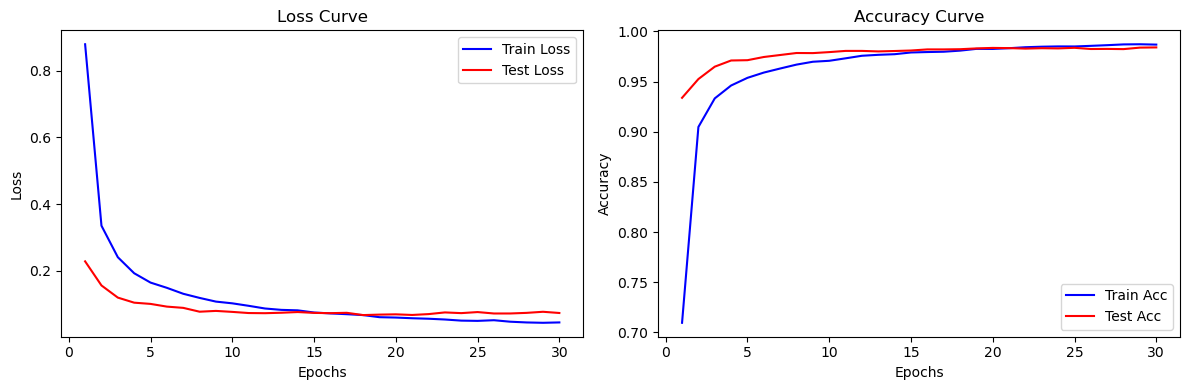


=== 开始实验: {'depth': [784, 512, 256, 128, 64, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.9792 | Test Loss: 0.5193 | Train Acc: 0.6448 | Test Acc: 0.8081
Epoch 2/30 | Train Loss: 0.5876 | Test Loss: 0.4269 | Train Acc: 0.7904 | Test Acc: 0.8474
Epoch 3/30 | Train Loss: 0.5064 | Test Loss: 0.3920 | Train Acc: 0.8210 | Test Acc: 0.8553
Epoch 4/30 | Train Loss: 0.4751 | Test Loss: 0.3838 | Train Acc: 0.8342 | Test Acc: 0.8602
Epoch 5/30 | Train Loss: 0.4464 | Test Loss: 0.3645 | Train Acc: 0.8436 | Test Acc: 0.8679
Epoch 6/30 | Train Loss: 0.4284 | Test Loss: 0.3593 | Train Acc: 0.8491 | Test Acc: 0.8685
Epoch 7/30 | Train Loss: 0.4142 | Test Loss: 0.3433 | Train Acc: 0.8540 | Test Acc: 0.8748
Epoch 8/30 | Train Loss: 0.4037 | Test Loss: 0.3408 | Train Acc: 0.8568 | Test Acc: 0.8785
Epoch 9/30 | Train Loss: 0.3925 | Test Loss: 0.3372 | Train Acc: 0.8610 | Test Acc: 0.8721
Epoch 10/30 | Train Loss: 0.3793 | Test Loss: 0.32

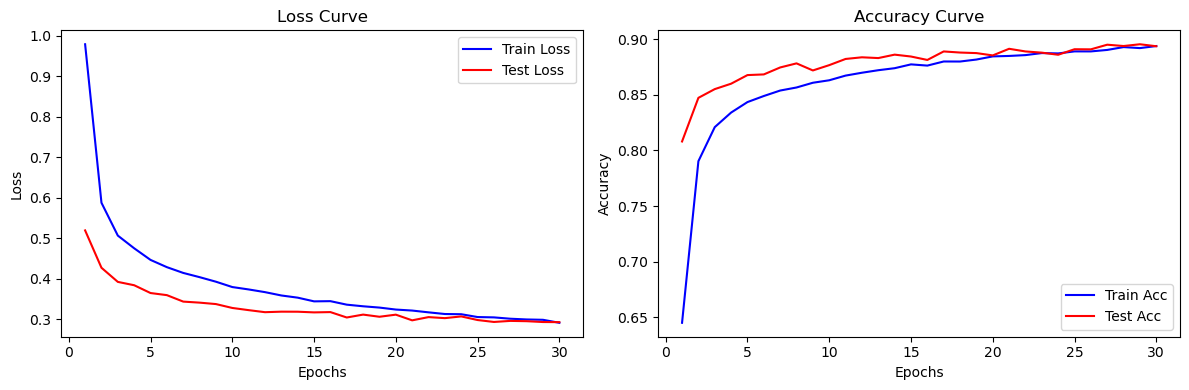


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.4792 | Test Loss: 0.1880 | Train Acc: 0.8553 | Test Acc: 0.9435
Epoch 2/30 | Train Loss: 0.2213 | Test Loss: 0.1361 | Train Acc: 0.9327 | Test Acc: 0.9586
Epoch 3/30 | Train Loss: 0.1692 | Test Loss: 0.1080 | Train Acc: 0.9498 | Test Acc: 0.9653
Epoch 4/30 | Train Loss: 0.1410 | Test Loss: 0.0951 | Train Acc: 0.9580 | Test Acc: 0.9692
Epoch 5/30 | Train Loss: 0.1239 | Test Loss: 0.0845 | Train Acc: 0.9628 | Test Acc: 0.9734
Epoch 6/30 | Train Loss: 0.1107 | Test Loss: 0.0795 | Train Acc: 0.9662 | Test Acc: 0.9753
Epoch 7/30 | Train Loss: 0.0972 | Test Loss: 0.0759 | Train Acc: 0.9696 | Test Acc: 0.9761
Epoch 8/30 | Train Loss: 0.0888 | Test Loss: 0.0797 | Train Acc: 0.9722 | Test Acc: 0.9764
Epoch 9/30 | Train Loss: 0.0847 | Test Loss: 0.0696 | Train Acc: 0.9736 | Test Acc: 0.9787
Epoch 10/30 | Train Loss: 0.0792 | Test Loss: 0.0678 | Train 

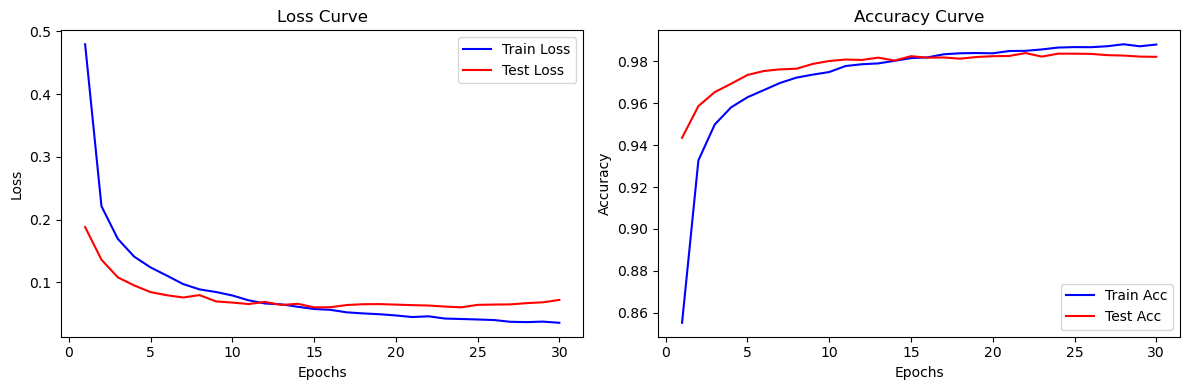


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.6665 | Test Loss: 0.4335 | Train Acc: 0.7649 | Test Acc: 0.8444
Epoch 2/30 | Train Loss: 0.4615 | Test Loss: 0.3912 | Train Acc: 0.8347 | Test Acc: 0.8597
Epoch 3/30 | Train Loss: 0.4203 | Test Loss: 0.3569 | Train Acc: 0.8474 | Test Acc: 0.8709
Epoch 4/30 | Train Loss: 0.3948 | Test Loss: 0.3426 | Train Acc: 0.8567 | Test Acc: 0.8747
Epoch 5/30 | Train Loss: 0.3746 | Test Loss: 0.3474 | Train Acc: 0.8641 | Test Acc: 0.8749
Epoch 6/30 | Train Loss: 0.3621 | Test Loss: 0.3229 | Train Acc: 0.8687 | Test Acc: 0.8816
Epoch 7/30 | Train Loss: 0.3541 | Test Loss: 0.3206 | Train Acc: 0.8721 | Test Acc: 0.8828
Epoch 8/30 | Train Loss: 0.3455 | Test Loss: 0.3209 | Train Acc: 0.8734 | Test Acc: 0.8844
Epoch 9/30 | Train Loss: 0.3367 | Test Loss: 0.3093 | Train Acc: 0.8765 | Test Acc: 0.8838
Epoch 10/30 | Train Loss: 0.3311 | Test Loss: 0.3083 | Trai

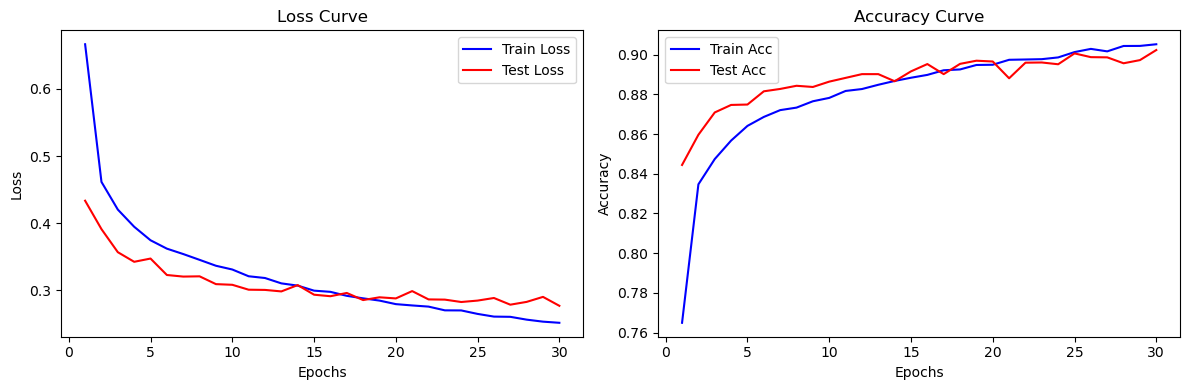


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'sigmoid', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.9474 | Test Loss: 0.3770 | Train Acc: 0.7553 | Test Acc: 0.9013
Epoch 2/30 | Train Loss: 0.3819 | Test Loss: 0.2722 | Train Acc: 0.8912 | Test Acc: 0.9222
Epoch 3/30 | Train Loss: 0.3050 | Test Loss: 0.2290 | Train Acc: 0.9098 | Test Acc: 0.9328
Epoch 4/30 | Train Loss: 0.2639 | Test Loss: 0.2021 | Train Acc: 0.9221 | Test Acc: 0.9378
Epoch 5/30 | Train Loss: 0.2324 | Test Loss: 0.1780 | Train Acc: 0.9303 | Test Acc: 0.9459
Epoch 6/30 | Train Loss: 0.2114 | Test Loss: 0.1616 | Train Acc: 0.9363 | Test Acc: 0.9514
Epoch 7/30 | Train Loss: 0.1932 | Test Loss: 0.1502 | Train Acc: 0.9420 | Test Acc: 0.9559
Epoch 8/30 | Train Loss: 0.1781 | Test Loss: 0.1382 | Train Acc: 0.9463 | Test Acc: 0.9584
Epoch 9/30 | Train Loss: 0.1664 | Test Loss: 0.1297 | Train Acc: 0.9495 | Test Acc: 0.9616
Epoch 10/30 | Train Loss: 0.1535 | Test Loss: 0.1212 | Tra

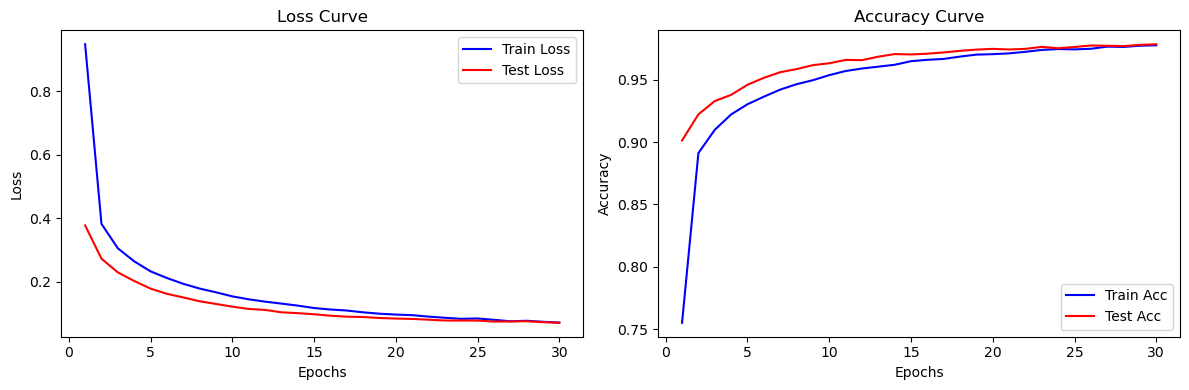


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'sigmoid', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.9364 | Test Loss: 0.5661 | Train Acc: 0.6936 | Test Acc: 0.7982
Epoch 2/30 | Train Loss: 0.5487 | Test Loss: 0.4736 | Train Acc: 0.8038 | Test Acc: 0.8333
Epoch 3/30 | Train Loss: 0.4865 | Test Loss: 0.4337 | Train Acc: 0.8234 | Test Acc: 0.8450
Epoch 4/30 | Train Loss: 0.4547 | Test Loss: 0.4116 | Train Acc: 0.8345 | Test Acc: 0.8544
Epoch 5/30 | Train Loss: 0.4337 | Test Loss: 0.3980 | Train Acc: 0.8426 | Test Acc: 0.8565
Epoch 6/30 | Train Loss: 0.4183 | Test Loss: 0.3846 | Train Acc: 0.8482 | Test Acc: 0.8632
Epoch 7/30 | Train Loss: 0.4047 | Test Loss: 0.3753 | Train Acc: 0.8528 | Test Acc: 0.8661
Epoch 8/30 | Train Loss: 0.3956 | Test Loss: 0.3670 | Train Acc: 0.8561 | Test Acc: 0.8703
Epoch 9/30 | Train Loss: 0.3855 | Test Loss: 0.3593 | Train Acc: 0.8606 | Test Acc: 0.8719
Epoch 10/30 | Train Loss: 0.3778 | Test Loss: 0.3534 | T

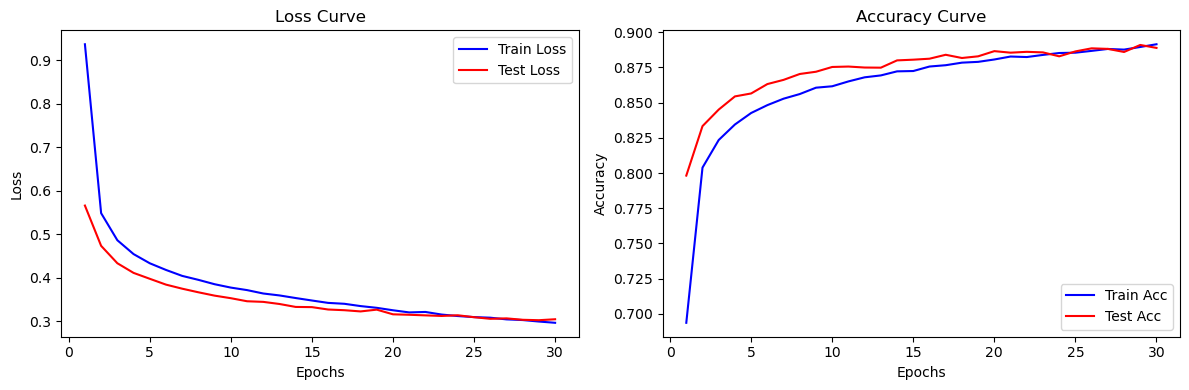


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'tanh', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.4451 | Test Loss: 0.2523 | Train Acc: 0.8687 | Test Acc: 0.9255
Epoch 2/30 | Train Loss: 0.2736 | Test Loss: 0.1989 | Train Acc: 0.9187 | Test Acc: 0.9433
Epoch 3/30 | Train Loss: 0.2292 | Test Loss: 0.1687 | Train Acc: 0.9306 | Test Acc: 0.9498
Epoch 4/30 | Train Loss: 0.1981 | Test Loss: 0.1492 | Train Acc: 0.9412 | Test Acc: 0.9551
Epoch 5/30 | Train Loss: 0.1752 | Test Loss: 0.1324 | Train Acc: 0.9482 | Test Acc: 0.9607
Epoch 6/30 | Train Loss: 0.1592 | Test Loss: 0.1253 | Train Acc: 0.9519 | Test Acc: 0.9619
Epoch 7/30 | Train Loss: 0.1441 | Test Loss: 0.1127 | Train Acc: 0.9571 | Test Acc: 0.9651
Epoch 8/30 | Train Loss: 0.1337 | Test Loss: 0.1059 | Train Acc: 0.9590 | Test Acc: 0.9681
Epoch 9/30 | Train Loss: 0.1235 | Test Loss: 0.1051 | Train Acc: 0.9628 | Test Acc: 0.9675
Epoch 10/30 | Train Loss: 0.1162 | Test Loss: 0.0971 | Train 

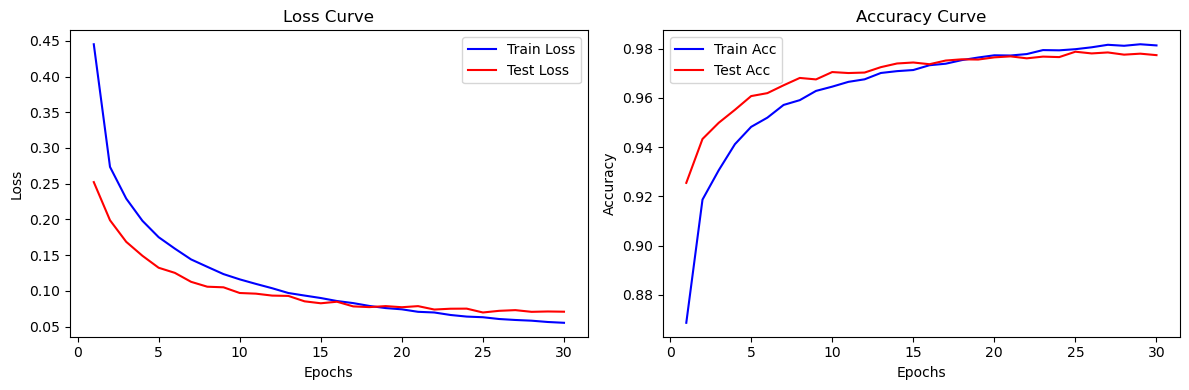


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'tanh', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.6136 | Test Loss: 0.4548 | Train Acc: 0.7805 | Test Acc: 0.8375
Epoch 2/30 | Train Loss: 0.4648 | Test Loss: 0.4085 | Train Acc: 0.8322 | Test Acc: 0.8557
Epoch 3/30 | Train Loss: 0.4283 | Test Loss: 0.3900 | Train Acc: 0.8467 | Test Acc: 0.8630
Epoch 4/30 | Train Loss: 0.4072 | Test Loss: 0.3940 | Train Acc: 0.8514 | Test Acc: 0.8566
Epoch 5/30 | Train Loss: 0.3916 | Test Loss: 0.3780 | Train Acc: 0.8580 | Test Acc: 0.8612
Epoch 6/30 | Train Loss: 0.3760 | Test Loss: 0.3642 | Train Acc: 0.8634 | Test Acc: 0.8711
Epoch 7/30 | Train Loss: 0.3654 | Test Loss: 0.3428 | Train Acc: 0.8686 | Test Acc: 0.8772
Epoch 8/30 | Train Loss: 0.3545 | Test Loss: 0.3416 | Train Acc: 0.8723 | Test Acc: 0.8752
Epoch 9/30 | Train Loss: 0.3498 | Test Loss: 0.3463 | Train Acc: 0.8720 | Test Acc: 0.8729
Epoch 10/30 | Train Loss: 0.3416 | Test Loss: 0.3488 | Trai

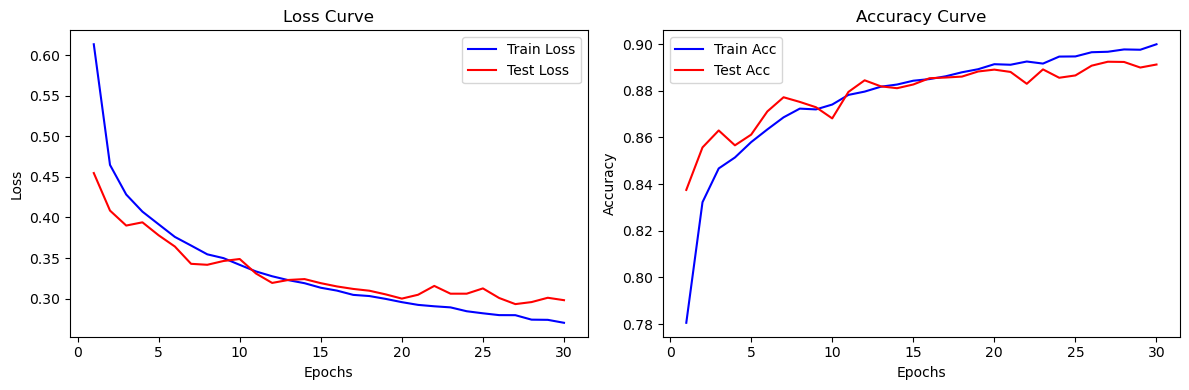


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 0.4866 | Test Loss: 0.1860 | Train Acc: 0.8532 | Test Acc: 0.9424
Epoch 2/30 | Train Loss: 0.2219 | Test Loss: 0.1352 | Train Acc: 0.9341 | Test Acc: 0.9594
Epoch 3/30 | Train Loss: 0.1693 | Test Loss: 0.1114 | Train Acc: 0.9496 | Test Acc: 0.9645
Epoch 4/30 | Train Loss: 0.1402 | Test Loss: 0.0957 | Train Acc: 0.9579 | Test Acc: 0.9699
Epoch 5/30 | Train Loss: 0.1222 | Test Loss: 0.0886 | Train Acc: 0.9621 | Test Acc: 0.9725
Epoch 6/30 | Train Loss: 0.1101 | Test Loss: 0.0810 | Train Acc: 0.9663 | Test Acc: 0.9749
Epoch 7/30 | Train Loss: 0.0974 | Test Loss: 0.0744 | Train Acc: 0.9701 | Test Acc: 0.9756
Epoch 8/30 | Train Loss: 0.0912 | Test Loss: 0.0714 | Train Acc: 0.9715 | Test Acc: 0.9768
Epoch 9/30 | Train Loss: 0.0827 | Test Loss: 0.0695 | Train Acc: 0.9742 | Test Acc: 0.9780
Epoch 10/30 | Train Loss: 0.0773 | Test Loss: 0.0719 | Train 

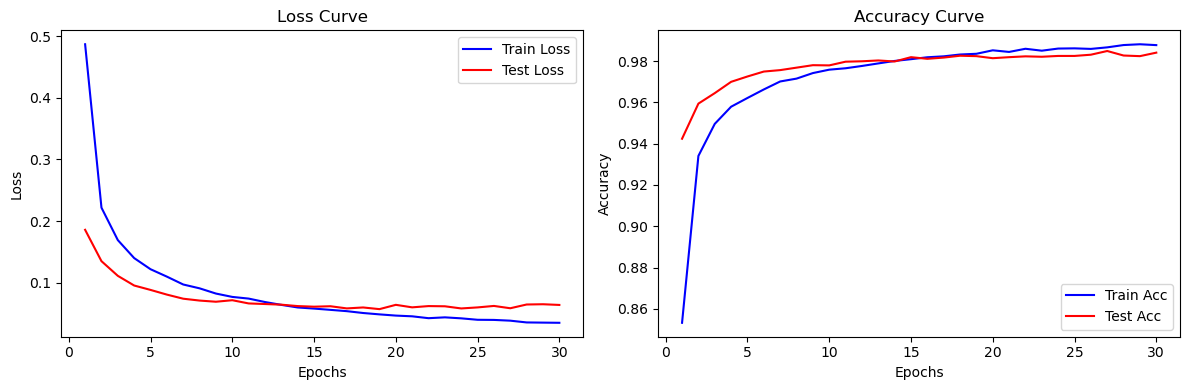


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 0.6743 | Test Loss: 0.4374 | Train Acc: 0.7615 | Test Acc: 0.8455
Epoch 2/30 | Train Loss: 0.4615 | Test Loss: 0.3819 | Train Acc: 0.8362 | Test Acc: 0.8615
Epoch 3/30 | Train Loss: 0.4208 | Test Loss: 0.3634 | Train Acc: 0.8497 | Test Acc: 0.8710
Epoch 4/30 | Train Loss: 0.3952 | Test Loss: 0.3450 | Train Acc: 0.8570 | Test Acc: 0.8730
Epoch 5/30 | Train Loss: 0.3791 | Test Loss: 0.3306 | Train Acc: 0.8642 | Test Acc: 0.8790
Epoch 6/30 | Train Loss: 0.3621 | Test Loss: 0.3192 | Train Acc: 0.8694 | Test Acc: 0.8841
Epoch 7/30 | Train Loss: 0.3539 | Test Loss: 0.3153 | Train Acc: 0.8711 | Test Acc: 0.8845
Epoch 8/30 | Train Loss: 0.3423 | Test Loss: 0.3099 | Train Acc: 0.8739 | Test Acc: 0.8871
Epoch 9/30 | Train Loss: 0.3344 | Test Loss: 0.3039 | Train Acc: 0.8777 | Test Acc: 0.8867
Epoch 10/30 | Train Loss: 0.3240 | Test Loss: 0.3115 | Trai

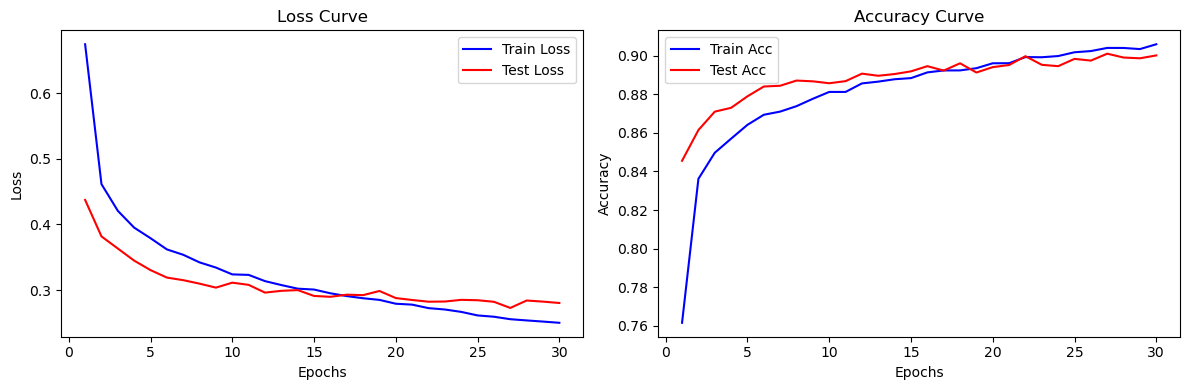


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('sgd', 0.01), 'dataset': 'mnist'} ===
Epoch 1/30 | Train Loss: 2.4176 | Test Loss: 2.2757 | Train Acc: 0.1042 | Test Acc: 0.1447
Epoch 2/30 | Train Loss: 2.3211 | Test Loss: 2.1822 | Train Acc: 0.1337 | Test Acc: 0.2268
Epoch 3/30 | Train Loss: 2.2435 | Test Loss: 2.1020 | Train Acc: 0.1686 | Test Acc: 0.3012
Epoch 4/30 | Train Loss: 2.1733 | Test Loss: 2.0290 | Train Acc: 0.2069 | Test Acc: 0.3613
Epoch 5/30 | Train Loss: 2.1069 | Test Loss: 1.9599 | Train Acc: 0.2460 | Test Acc: 0.4321
Epoch 6/30 | Train Loss: 2.0477 | Test Loss: 1.8926 | Train Acc: 0.2806 | Test Acc: 0.4969
Epoch 7/30 | Train Loss: 1.9906 | Test Loss: 1.8266 | Train Acc: 0.3164 | Test Acc: 0.5520
Epoch 8/30 | Train Loss: 1.9300 | Test Loss: 1.7611 | Train Acc: 0.3535 | Test Acc: 0.5945
Epoch 9/30 | Train Loss: 1.8715 | Test Loss: 1.6964 | Train Acc: 0.3908 | Test Acc: 0.6276
Epoch 10/30 | Train Loss: 1.8164 | Test Loss: 1.6321 | Train Acc:

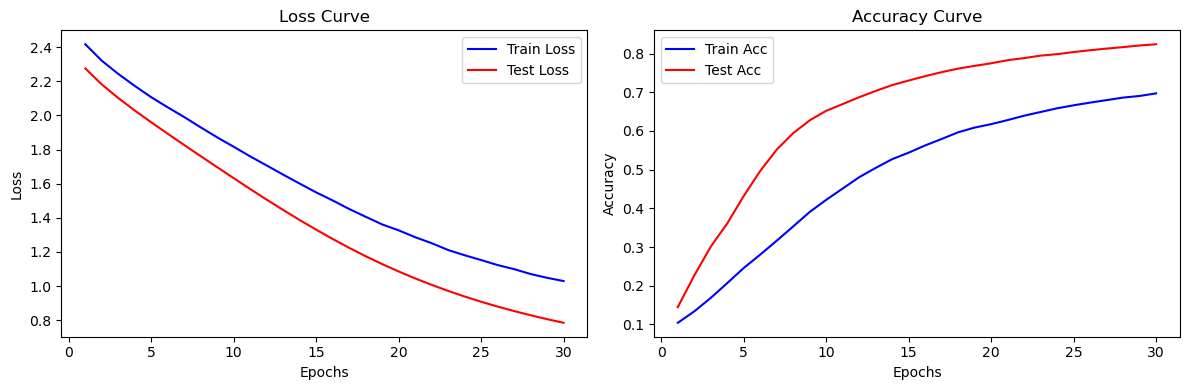


=== 开始实验: {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': ('sgd', 0.01), 'dataset': 'fashion'} ===
Epoch 1/30 | Train Loss: 2.4221 | Test Loss: 2.1880 | Train Acc: 0.1406 | Test Acc: 0.1943
Epoch 2/30 | Train Loss: 2.1981 | Test Loss: 2.0217 | Train Acc: 0.1933 | Test Acc: 0.3263
Epoch 3/30 | Train Loss: 2.0561 | Test Loss: 1.8862 | Train Acc: 0.2573 | Test Acc: 0.4023
Epoch 4/30 | Train Loss: 1.9406 | Test Loss: 1.7657 | Train Acc: 0.3171 | Test Acc: 0.4702
Epoch 5/30 | Train Loss: 1.8361 | Test Loss: 1.6567 | Train Acc: 0.3709 | Test Acc: 0.5297
Epoch 6/30 | Train Loss: 1.7411 | Test Loss: 1.5589 | Train Acc: 0.4140 | Test Acc: 0.5686
Epoch 7/30 | Train Loss: 1.6530 | Test Loss: 1.4714 | Train Acc: 0.4527 | Test Acc: 0.5954
Epoch 8/30 | Train Loss: 1.5816 | Test Loss: 1.3944 | Train Acc: 0.4782 | Test Acc: 0.6111
Epoch 9/30 | Train Loss: 1.5062 | Test Loss: 1.3270 | Train Acc: 0.5058 | Test Acc: 0.6205
Epoch 10/30 | Train Loss: 1.4527 | Test Loss: 1.2688 | Train Ac

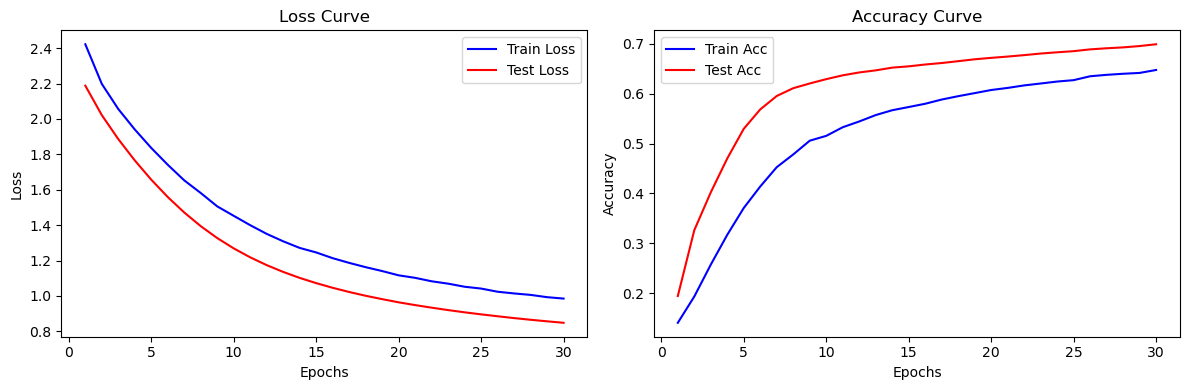

In [429]:
import numpy as np
import itertools

# 固定随机种子保证可复现性
np.random.seed(42)

# ================== 训练配置 ==================
configs = {
    'depth': [
        [784, 28, 10],              # 浅层网络
        [784, 256, 128, 10],        # 中等深度
        [784, 512, 256, 128, 64, 10]# 深层网络
    ],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'optimizer': [
        ('adam', 0.00035),
        ('sgd', 0.01)
    ],
    'dataset': ['mnist', 'fashion']
}

# ================== 网络构建工具 ==================
def build_network(layer_dims, activation):
    """动态构建网络结构"""
    net = Net()
    for i in range(len(layer_dims)-1):
        in_dim, out_dim = layer_dims[i], layer_dims[i+1]
        net.add(FullyConnected(in_dim, out_dim))
        
        # 添加激活函数（最后一层不添加）
        if i < len(layer_dims)-2:
            if activation == 'relu':
                net.add(Relu())
            elif activation == 'sigmoid':
                net.add(Sigmoid())
            elif activation == 'tanh':
                net.add(Tanh())
            
            # 中等和深层网络添加Dropout
            if len(layer_dims) > 3 and i < len(layer_dims)-3:
                net.add(Dropout(p=0.5))
    
    net.add(Softmax())
    return net

# ================== 优化器选择 ==================
def get_optimizer(model, opt_config):
    opt_type, lr = opt_config
    params = model.parameters()
    if opt_type == 'adam':
        return Adam(params, lr=lr)
    elif opt_type == 'sgd':
        return SGD(params, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_type}")

# ================== 数据加载 ==================
def load_data(dataset_name):
    if dataset_name == 'mnist':
        return train_loader_MNIST, test_loader_MNIST
    elif dataset_name == 'fashion':
        return train_loader_Fashion_MNIST, test_loader_Fashion_MNIST
    else:
        raise ValueError("Invalid dataset name")

# ================== 自动化训练入口 ==================
def run_experiments():
    # 实验组定义（按用户参数表）
    results = []
    experiments = [
        # 组1: 不同深度
        {'depth': c, 'activation': 'relu', 'optimizer': ('adam', 0.00035), 'dataset': d}
        for c in configs['depth']
        for d in configs['dataset']
    ] + [
        # 组2: 不同激活函数
        {'depth': [784, 256, 128, 10], 'activation': a, 'optimizer': ('adam', 0.00035), 'dataset': d}
        for a in configs['activation']
        for d in configs['dataset']
    ] + [
        # 组3: 不同优化器
        {'depth': [784, 256, 128, 10], 'activation': 'relu', 'optimizer': o, 'dataset': d}
        for o in configs['optimizer']
        for d in configs['dataset']
    ]

    # 运行所有实验
    for exp in experiments:
        print(f"\n=== 开始实验: {exp} ===")
        
        # 1. 准备数据
        train_loader, test_loader = load_data(exp['dataset'])
        
        # 2. 构建网络
        model = build_network(exp['depth'], exp['activation'])
        
        # 3. 初始化优化器
        optimizer = get_optimizer(model, exp['optimizer'])
        
        # 4. 训练模型
        criterion = CrossEntropy()
        train(model, train_loader, test_loader, criterion, optimizer, epochs=30, plot=True)
        
        # 5. 记录结果
        results.append({
            'depth': exp['depth'],
            'activation': exp['activation'],
            'optimizer': exp['optimizer'][0],  # 只取优化器名称
            'dataset': exp['dataset'],
            'accuracy': accuracy  # 假设train函数返回测试准确率
        })


# 执行所有实验
run_experiments()

## HeatMap

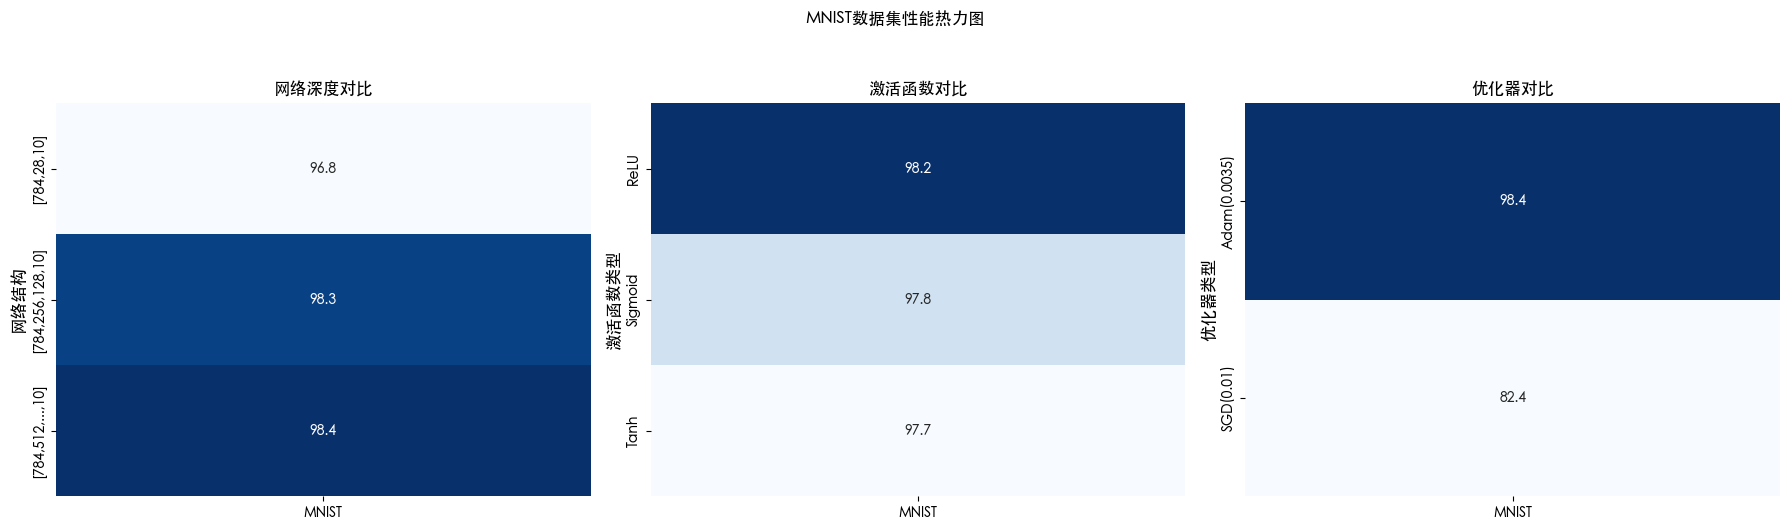

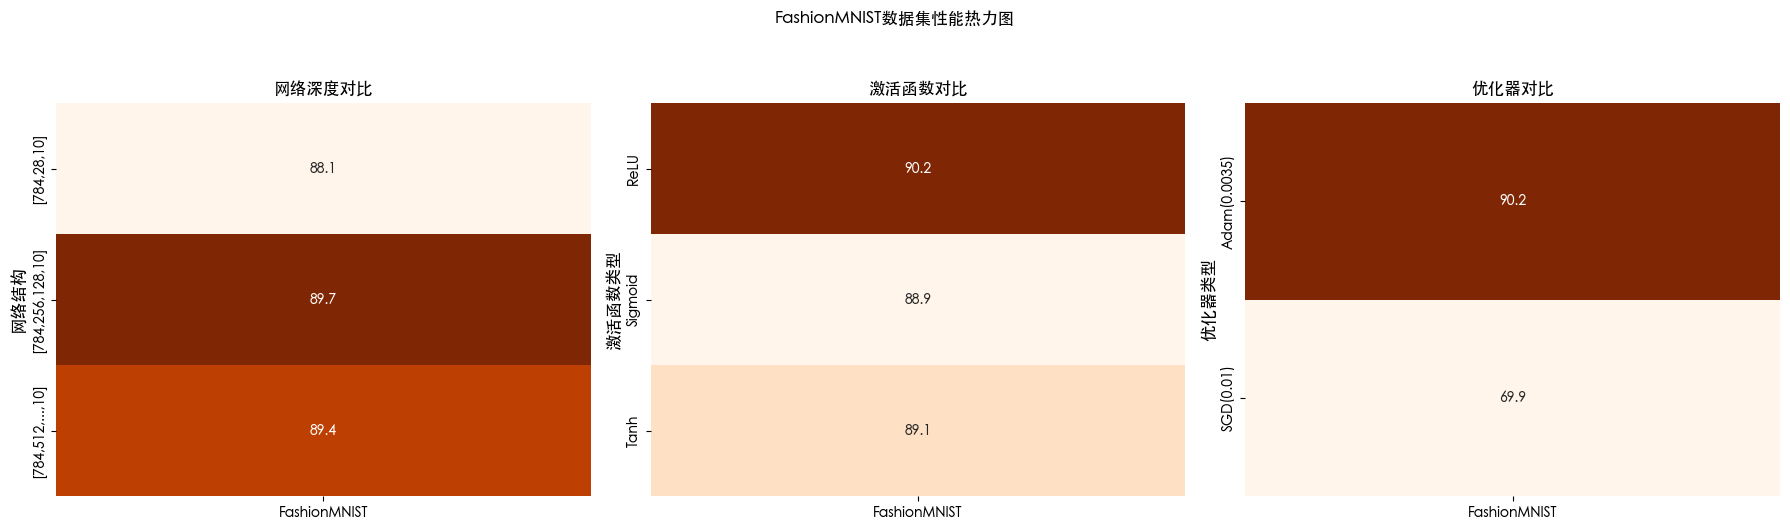

In [433]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.font_manager import FontProperties

# ====================== 数据准备 ======================
# 网络深度对比数据
depth_labels = ['[784,28,10]', '[784,256,128,10]', '[784,512,...,10]']
mnist_depth = np.array([[96.8], [98.3], [98.4]])  # MNIST准确率
fashion_depth = np.array([[88.1], [89.7], [89.4]])  # FashionMNIST准确率

# 激活函数对比数据
act_labels = ['ReLU', 'Sigmoid', 'Tanh']
mnist_act = np.array([[98.2], [97.8], [97.7]])     # MNIST准确率
fashion_act = np.array([[90.2], [88.9], [89.1]])   # FashionMNIST准确率

# 优化器对比数据
opt_labels = ['Adam(0.0035)', 'SGD(0.01)']
mnist_opt = np.array([[98.4], [82.4]])             # MNIST准确率
fashion_opt = np.array([[90.2], [69.9]])          # FashionMNIST准确率

# ====================== 字体设置 ======================
# 使用 macOS 自带的中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'  # PingFang 字体路径
if not os.path.exists(font_path):
    font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # 备用字体：华文黑体

# 加载字体
font = FontProperties(fname=font_path, size=12)

# 设置全局字体
plt.rcParams['font.family'] = font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# ====================== 绘制热力图 ======================
# ---- MNIST数据集 ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 网络深度
sns.heatmap(mnist_depth, annot=True, fmt=".1f", cmap="Blues", ax=axes[0],
           xticklabels=["MNIST"], yticklabels=depth_labels, cbar=False)
axes[0].set_title("网络深度对比", fontproperties=font)
axes[0].set_xlabel("")
axes[0].set_ylabel("网络结构", fontproperties=font)

# 激活函数
sns.heatmap(mnist_act, annot=True, fmt=".1f", cmap="Blues", ax=axes[1],
           xticklabels=["MNIST"], yticklabels=act_labels, cbar=False)
axes[1].set_title("激活函数对比", fontproperties=font)
axes[1].set_xlabel("")
axes[1].set_ylabel("激活函数类型", fontproperties=font)

# 优化器
sns.heatmap(mnist_opt, annot=True, fmt=".1f", cmap="Blues", ax=axes[2],
           xticklabels=["MNIST"], yticklabels=opt_labels, cbar=False)
axes[2].set_title("优化器对比", fontproperties=font)
axes[2].set_xlabel("")
axes[2].set_ylabel("优化器类型", fontproperties=font)

plt.suptitle("MNIST数据集性能热力图", fontproperties=font, y=1.05)
plt.tight_layout()

# ---- FashionMNIST数据集 ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 网络深度
sns.heatmap(fashion_depth, annot=True, fmt=".1f", cmap="Oranges", ax=axes[0],
           xticklabels=["FashionMNIST"], yticklabels=depth_labels, cbar=False)
axes[0].set_title("网络深度对比", fontproperties=font)
axes[0].set_xlabel("")
axes[0].set_ylabel("网络结构", fontproperties=font)

# 激活函数
sns.heatmap(fashion_act, annot=True, fmt=".1f", cmap="Oranges", ax=axes[1],
           xticklabels=["FashionMNIST"], yticklabels=act_labels, cbar=False)
axes[1].set_title("激活函数对比", fontproperties=font)
axes[1].set_xlabel("")
axes[1].set_ylabel("激活函数类型", fontproperties=font)

# 优化器
sns.heatmap(fashion_opt, annot=True, fmt=".1f", cmap="Oranges", ax=axes[2],
           xticklabels=["FashionMNIST"], yticklabels=opt_labels, cbar=False)
axes[2].set_title("优化器对比", fontproperties=font)
axes[2].set_xlabel("")
axes[2].set_ylabel("优化器类型", fontproperties=font)

plt.suptitle("FashionMNIST数据集性能热力图", fontproperties=font, y=1.05)
plt.tight_layout()
plt.show()